In [38]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns 
import scipy
import math
import random 
from scipy import stats
import statistics

### first up: processing

In [2]:
random.seed(1)

In [3]:
drop_cols = ['Unnamed: 0', 'Allowed', 'Subject', 'StudioVersion', 'leftarrow', 'rightarrow', 'triggercode',
            'Clock.Information', 'DataFile.Basename', 'Display.RefreshRate', 'ExperimentName', 
            'Procedure[Block]', 'Procedure[Trial]', 'RandomSeed', 'Running[Block]', 'Running[SubTrial]', 
            'Running[Trial]', 'RuntimeCapabilities', 'RuntimeVersion', 'RuntimeVersionExpected']


In [4]:
#this makes it so that the WHOLE dataframe prints, just fyi, this can bog down your code

pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', 199)  # or 199

In [5]:
SST_concat = pd.read_csv('SST_cleaned_7231_all_rows_all_columns.csv').drop(drop_cols, axis =1)

/Users/work/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,15,38,82,105,115,116) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### first, a few qa checks: 

In [6]:
#check these values - they shouldn't be over 1000ms 
sum(SST_concat['go_stim_duration'] > 1000)

0

In [7]:
#check len - should be 2mil 
assert len(SST_concat) == 2603160

In [8]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'IncorrectGo'])

304756

In [9]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'CorrectGo'])

1864544

In [10]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'CorrectStop'])

221501

In [11]:
len(SST_concat.loc[SST_concat['TrialCode'] == 'IncorrectStop'])

212359

In [12]:
#assertion about stop_rt_adjusted and go_rt_adjusted

In [13]:
#build in a few more here - for trial code correctness and 

### Issue 1:  Different go stimulus duration across trials

mean duration go stimulus on go trials

In [44]:
print(np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial']))
print(np.std(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial']))
statistics.stdev(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial'])

566.8983810445766
221.8583268472381


221.85837798265038

mean duration go stimulus on stop trials

In [43]:
print(np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial']))
print(np.std(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial']))
statistics.stdev(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial'])

226.26519845111326
151.63924909734422


151.6394238536057

difference of these

In [56]:
np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial']) \
    - np.mean(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial'].dropna())

340.6331825934633

plot to show how drastic this is

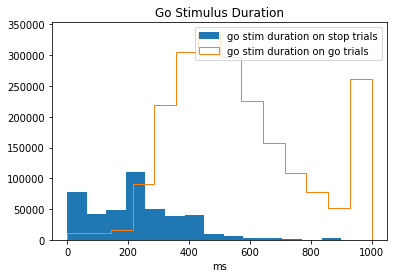

In [57]:
plt.hist(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial'].dropna(), bins = 14, label = "go stim duration on stop trials")
plt.xlabel('ms')
plt.title('Go Stimulus Duration')

#SSDUR.value_counts()
plt.hist(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial'].dropna(), bins = 14, histtype='step',\
          label = "go stim duration on go trials")
#plt.axvline(x=mean_SSD, color = 'r', label = "mean SSD")
plt.legend()
plt.show()


mean go.rt vs. mean stop failure & how many subjects mean stop failure is longer than mean rt 

stop failure RT 

In [18]:
np.mean(SST_concat.loc[SST_concat['TrialCode'] == 'IncorrectStop']['stop_rt_adjusted'])

476.20389529052215

In [19]:
np.mean(SST_concat.loc[SST_concat['correct_stop'] == 0]['stop_rt_adjusted'])

480.87264500398555

overt go response rt 

In [20]:
np.mean(SST_concat.loc[SST_concat['correct_go_response'] != 'omission']['go_rt_adjusted'])

541.8450486026431

let's look at the averages by participant now: 

In [21]:
group_narguid = SST_concat.groupby('NARGUID')

In [60]:
#lambda x lets us apply np.mean to each group
narguid_average_stop_rt = group_narguid.apply(lambda x: \
                                                np.mean(x.loc[x['correct_stop'] == 0]['stop_rt_adjusted']))

In [61]:
np.mean(narguid_average_stop_rt)

495.01266545367145

In [54]:
narguid_average_go_rt = group_narguid.apply(lambda x: np.mean(x.loc[(x['correct_go_response'] != 'omission') \
                                                                    & (x['trial_type'] == 'GoTrial')]['go_rt_adjusted']))

In [55]:
np.mean(narguid_average_go_rt)

543.6630781157475

In [30]:
narguid_df = pd.DataFrame({'stop_rt': narguid_average_stop_rt,'go_rt':narguid_average_go_rt})
narguid_df = narguid_df.dropna(axis = 0, how='any')

In [35]:
from scipy.stats import ttest_rel, ttest_ind
ttest_rel(narguid_df['stop_rt'], narguid_df['go_rt'])

Ttest_relResult(statistic=-50.43897121649605, pvalue=0.0)

In [50]:
sum(np.greater(narguid_average_stop_rt, narguid_average_go_rt)) / 7231

0.18337712626192781

### Issue 2: Go Stimulus sometimes not presented

percentage of trials with SSD == 0, and therefor, no go stimulus

In [ ]:
len(SST_concat.loc[SST_concat['SSDDur'] == 0])/\
    len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'])

rt on these trials

In [ ]:
np.mean(SST_concat.loc[SST_concat['SSDDur'] == 0]['stop_rt_adjusted'])

percent of accuracy when SSD == 0 

In [ ]:
len(SST_concat.loc[(SST_concat['SSDDur'] == 0) & (SST_concat['correct_stop'] == 1.0)])/ \
    len(SST_concat.loc[SST_concat['SSDDur'] == 0])

### Issue 3: Non-uniform conditional trial probabilities

In [ ]:
#set up expected duration
x = np.arange(0,20, 1) 
def my_dist(i):
    i = (1/6) * (5/6)**(i)
    return(i)  
p = my_dist(x)

In [ ]:
stop_prob_index = SST_concat.loc[SST_concat['StopTrial'] !=1].index

In [ ]:
plt.hist(SST_concat['Stop_nback'].dropna(), normed=True, bins = 20, label = 'ABCD Data conditional probability')
plt.plot(x,p, label = 'random conditional probability of a stop signal')
plt.xlabel('number of go trials in between stop trials')
plt.title('Non-uniform conditional trial probabilities')

plt.xticks(np.arange(0, 21, step=2))
plt.legend()
plt.show()

conditional probability of a stop signal, given a stop signal occured two trials ago

In [ ]:
one_back = SST_concat.loc[SST_concat['Stop_nback'] == 1] 
stop_nback = SST_concat.loc[~SST_concat['Stop_nback'].isnull()]['Stop_nback']
print("percent of trials with stop signals sepreated by one go trial:", len(one_back) / len(stop_nback) * 100) 

lets figure out this post stop slowing! 

In [ ]:
#find the stop trials
stop_mask = ~SST_concat['StopTrial'].isnull()
stop_idx = stop_mask[stop_mask == True].index
#make the new column
SST_concat['signal_slowing_1'] = np.NaN
SST_concat['signal_slowing_2'] = np.NaN
SST_concat['signal_slowing_3'] = np.NaN

#get the pre-stop rt
pre_stop_rt = SST_concat['go_rt_adjusted'].loc[stop_idx - 1] 
#get the post-stop rt

post_stop_rt_1 = SST_concat['go_rt_adjusted'].loc[stop_idx + 1]
post_stop_rt_2 = SST_concat['go_rt_adjusted'].loc[stop_idx + 2]
post_stop_rt_3 = SST_concat['go_rt_adjusted'].loc[stop_idx + 3]

SST_concat['signal_slowing_1'][stop_idx]= np.array(post_stop_rt_1) - np.array(pre_stop_rt)
SST_concat['signal_slowing_2'][stop_idx]= np.array(post_stop_rt_2) - np.array(pre_stop_rt)
SST_concat['signal_slowing_3'][stop_idx]= np.array(post_stop_rt_3) - np.array(pre_stop_rt)


In [ ]:
NARGUID_signal_slowing.describe()

In [ ]:
NARGUID_signal_slowing = SST_concat.groupby('NARGUID').apply(lambda x: np.mean(x['signal_slowing_1']))

In [ ]:
stop_slowing_1 = [] 
stop_slowing_2 = [] 
stop_slowing_3 = [] 

for i in np.arange(2, 60, 1):
    stop_slowing_1.append(np.nanmean(SST_concat['signal_slowing_1'].loc[(SST_concat['StopTrial'] == i)]))
    stop_slowing_2.append(np.nanmean(SST_concat['signal_slowing_2'].loc[(SST_concat['StopTrial'] == i)]))
    stop_slowing_3.append(np.nanmean(SST_concat['signal_slowing_3'].loc[(SST_concat['StopTrial'] == i)]))

In [ ]:
quartile_slowing = [] 
quartile_slowing.append(np.mean(stop_slowing[1:10]))
quartile_slowing.append(np.mean(stop_slowing[10:20]))
quartile_slowing.append(np.mean(stop_slowing[20:30]))
quartile_slowing.append(np.mean(stop_slowing[40:50]))
quartile_slowing.append(np.mean(stop_slowing[50:60]))

In [ ]:
stop_failure_slowing = []
stop_success_slowing = []
for i in np.arange(1, 61, 1):
    stop_failure_slowing.append(np.mean(SST_concat['signal_slowing'].loc[(SST_concat['StopTrial'] == i) &
                                                                  (SST_concat['TrialCode'] == 'IncorrectStop')]))
    stop_success_slowing.append(np.mean(SST_concat['signal_slowing'].loc[(SST_concat['StopTrial'] == i) &
                                                                  (SST_concat['TrialCode'] == 'CorrectStop')]))

In [ ]:
quartile_stop_success_slowing = [] 
quartile_stop_failure_slowing = [] 
for i in np.arange(1, 16, 1):
    quartile_stop_failure_slowing.append(np.mean(SST_concat['signal_slowing'].loc[(SST_concat['StopTrial'] == i) &
                                                                  (SST_concat['TrialCode'] == 'IncorrectStop')]))
    quartile_stop_success_slowing.append(np.mean(SST_concat['signal_slowing'].loc[(SST_concat['StopTrial'] == i) &
                                                                  (SST_concat['TrialCode'] == 'CorrectStop')]))


In [ ]:
np.mean(stop_slowing_1)

In [ ]:
plt.plot(np.arange(1, 59, 1), stop_slowing_1)
plt.title('post - pre stop rt slowing')
plt.show()

In [ ]:
plt.plot(np.arange(1, 6, 1), quartile_slowing)
plt.title('post - pre stop rt slowing')
plt.show()

In [ ]:
plt.title('post - pre stop rt slowing')
plt.plot(SST_concat['StopTrial'].dropna(), m*SST_concat['StopTrial'].dropna() + b, color='black')
plt.errorbar(np.arange(2, 61, 1), stop_slowing, yerr=stop_slowing_std,markersize=100,capsize=10,linestyle='None')

plt.show()

In [ ]:
plt.plot(np.arange(1, 61, 1), stop_failure_slowing)
plt.title('post - pre stop failure rt slowing')
plt.show()

In [ ]:
plt.plot(np.arange(1, 61, 1), stop_success_slowing)
plt.title('post - pre stop signal success slowing')
plt.show()

In [ ]:
plt.hist(SST_concat['go_rt_adjusted'].loc[~pd.isnull(SST_concat['go_rt_adjusted'].values)], bins = 20) 
plt.show()

#### Issue 4: Different stop signal stimulus duration for different SSDs

In [ ]:
len(SST_concat.loc[SST_concat['SSDDur'] > 700]) / 433860

In [ ]:
7231 * 60

In [ ]:
plt.hist(SSD, bins = 14)
plt.xlabel('ms')
plt.title('Stop Signal Delay')

#plt.axvline(x=mean_SSD, color = 'r', label = "mean SSD")
#plt.legend()
plt.show()

#### Issue 5: SSD can become stuck at 0ms


In [ ]:
SST_concat.loc[(SST_concat['SSD.RT'] < 100) & (SST_concat['SSD.RT'] > 0) & (SST_concat['SSDDur'] <=50)]\
     [['NARGUID', 'TrialNum', 'SSD.RT', 'SSD.RESP', 'SSDDur' ]]

In [ ]:
issue_5 = SST_concat.loc[(SST_concat['SSD.RT'] < 100) & (SST_concat['SSD.RT'] > 0) & (SST_concat['SSDDur'] <=50)]['NARGUID'].index# \

In [ ]:
SST_concat[SST_concat['SSDDur'] == 0].set_index('NARGUID').drop(issue_5_bug_NARGUIDS)

#### Issue 6: Trial accuracy incorrectly coded

#### Issue 7: SSD values start too short 


In [ ]:
num_stop = []
accuracy = [] 
avg_SSD = []
SSD_var = []
for i in np.arange(1, 61): 
    correct = SST_concat.loc[SST_concat['StopTrial'] ==i]['TrialCode'].value_counts()['CorrectStop']
    acc = correct / len(SST_concat.loc[SST_concat['StopTrial'] ==i]['TrialCode'])
    SSD = np.mean(SST_concat.loc[SST_concat['StopTrial'] ==i]['SSDDur'])
    var = np.std(SST_concat.loc[SST_concat['StopTrial'] ==i]['SSDDur'])
    SSD_var.append(var)
    num_stop.append(i)
    accuracy.append(acc)
    avg_SSD.append(SSD)
    
acc_df = pd.DataFrame() 
acc_df['StopTrial'] = num_stop 
acc_df['Accuracy'] = accuracy
acc_df['Avg_SSD'] = avg_SSD
acc_df['SSD_var'] = SSD_var

In [ ]:
plt.plot(acc_df['StopTrial'], acc_df['Accuracy'])
plt.xlabel('Stop Trial')
plt.ylabel('Stop Signal Accuracy')
plt.title('Stop signal accuracy by number of stop trial')

In [ ]:
plt.plot(acc_df['StopTrial'], acc_df['Avg_SSD'], color='black')

plt.fill_between(acc_df['StopTrial'], acc_df['Avg_SSD'] - acc_df['SSD_var'], acc_df['Avg_SSD'] + acc_df['SSD_var'], facecolor = 'teal', alpha=.25)

In [ ]:
np.mean(SST_concat['Go+Fix.RT'].dropna())

#### Issue 8: Low stop probability 